### <font color='blue'>分類器ベースのチャンカの訓練</font>

<font color='red'>見直し</font><br>
<ul>
<li>ユニグラムタガーを用いたチャンキング</li>
<li>チャンクの範囲の作成について</li>
<li>ここのページ</li>
<li>学習済みの分類器の保存</li>
</ul>

Nグラムタガーを用いるという、品詞タグがあまり有効出ない場合も存在する。<br>

例として以下の文章を考える。<br>

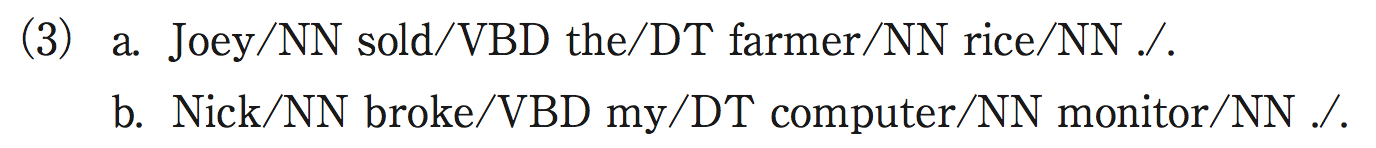

In [3]:
from IPython.display import Image
Image(filename='IMG/7-9.png', width=500)

最初の例については、farmerとriceが２つに分けられるが<br>
次の文章では、computerとmonitorが１つのチャンクになることに注意。<br>
したがって、品詞タグを使うだけでなく、単語の内容を用いることが重要になる。<br>

単語の内容に関する情報を利用するために、文のチャンキングに分類器ベースのタガーを利用する。<br>
分類器ベースのチャンカは<br>
文中の単語にIOBタグを割り当て、そのタグをチャンクに変換する。<br>

以下に分類器ベースのチャンカをみる。<br>

### <font color='blue'>連続分類器を利用した名詞句チャンキング</font>

In [49]:
import nltk

class ConsecutiveNPChunkTagger(nltk.TaggerI):
    
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='megam', trace=0)
    
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)
    
class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

次に素性抽出器を定義する。<br>

In [30]:
# 素性抽出器の定義
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos" : pos}

In [51]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='IIS', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [42]:
# ウォールストリート・ジャーナルのコーパスのimport
from nltk.corpus import conll2000

# 訓練用に文章からIBOフォーマットのNPチャンクのみの抜き出し
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
# テスト用にIBOフォーマットからNPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [52]:
chunker = ConsecutiveNPChunker(train_sents)

In [53]:
import pickle
import os

# np_chunkerディレクトリを作成し、pkl_objectsサブフォルダを作成
dest = os.path.join('np_chunker', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

# pkl_objectsサブフォルダに学習済みのclassifierのpklの保存
pickle.dump(chunker, open(os.path.join(dest, 'np_chunker_0.pkl'), 'wb'), protocol=4)

In [66]:
import os

clf = pickle.load(open(os.path.join('np_chunker_0.pkl'), 'rb'))

In [67]:
print(clf.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


### <font color='blue'>連続分類器を利用した名詞句チャンキングクラスと素性抽出器について詳しく見る</font>